## TD2. Vision Transformers
By Nicolas Dufour

In this TD, we will implement the Transformers architecture. Transformers has been a key architecture in deep learning for the past 5 years.

It has first began with NLP, then came audio and finally, since 2020, computer vision.
We will implement every block that makes a transformer from scratch and we will try to create a deep understanding of what is happening.
Here is a figure for the transformer architecture:


<img src="https://www.researchgate.net/profile/Miruna-Gheata/publication/355339249/figure/fig1/AS:1079476452622337@1634378650979/Encoder-decoder-architecture-of-the-Transformer-developed-by-Vaswani-et-al-28.ppm" width=768>

## Instructions
In `pytorch` you must avoid using for loops at all cost. It's almost always possible to find a vectorized version of the operation you want to implement.

**In this TP, the only for-loop you can do is the training loop.**

In [132]:
!pip install einops
!pip install timm

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import math
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange, repeat
from PIL import Image
from torchvision import transforms
import requests

# for function annotation
from typing import Tuple


torch.manual_seed(0)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Part 1. The attention mechanism

### Implementing the scaled dot-product attention mechanism

The transformer architecture is built around one key block: The attention.
The idea behind attention is the following. Imagine you want to retrieve information from a dictionary. The dictionnary is indexed by keys which maps to a particular value. Now, you have a query which will be matched against the keys of the dict and if you have a match, you will retrieve the associated value.
Attention is very similar to this simple retrieval example. Now, with real data, we don't have this structure, we however are going to learn to create it.

We have 2 sets of vectors (also named tokens). One is $X_{to}$ which is the destination set. We want to be able to map this set of tokens to queries. We achieve this by doing a linear projection of $X_{to}$ to obatain:  $Q = W_QX_{to}$

The other set is $X_{from}$ the set from which we want to retrieve information. We will need to extract both keys and values from this set. We therefore do 2 linear projections of $X_{from}$ to obtain:  $K = W_KX_{from}$ and $V = W_VX_{from}$.

Now, contrary to the dictionnary where queries and values are exact matchs, we don't have this here. Therefore, we will perform a softer match by computing the similarity matrix between $Q$ and $K$. Then for each $Q$, we want to output the values that have the higher similarity. We therefore output the weighted sum of the values, weighted by the softmax of the similarity (also called the attention matrix).

Finally, the attention operation is given by the cross attention:

$$
A(Q,K,V) = \text{SoftMax}(\frac{QK^T}{\sqrt{d_k}})V
$$

We divide the similarity by $\sqrt{d_k}$ for stability reason to avoid the similarity to explode with big vectors which would lead to very sharp attention coeficients.

#### Question 1.
Implement the attention operation, use  `torch.einsum` to easily compute the similarity matrix.

In [134]:
class Attention(nn.Module):
    def __init__(self, x_to_dim: int, x_from_dim: int, hidden_dim: int):
        """
        Initializes the Attention module.
        Args:
        - x_to_dim: Dim of the tensor (X_to).
        - x_from_dim: Dim of the tensor (X_from).
        - hidden_dim: Dim of the hidden representations Q, K, V.
        """
        # To complete
        super(Attention, self).__init__()
        '''
        Layers for Q, K, V
        Q = W_Q * X_to
        K = W_k * X_from
        V = W_V * X_from
        '''
        # Linear projections
        self.to_query = nn.Linear(x_to_dim, hidden_dim)
        self.to_key = nn.Linear(x_from_dim, hidden_dim)
        self.to_value = nn.Linear(x_from_dim, hidden_dim)

        pass

    def forward(self, x_to: torch.Tensor, x_from: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the attention mechanism.
        Args:
        - x_to: [batch size, x_to_len, x_to_dim] -> Queries source
        - x_from: [batch size, x_from_len, x_from_dim] -> Keys and Values source
        Returns:
        - Output: [batch size, x_to_len, hidden_dim]
        """
        # To complete
        Q = self.to_query(x_to) # [batch size, x_to_len, hidden_dim]
        K = self.to_key(x_from) # [batch size, x_from_len, hidden_dim]
        V = self.to_value(x_from) # [batch size, x_from_len, hidden_dim]
        '''
        K.shape = [B, x_t_len, h_d] -> K.T = [B, h_d, x_t_len]
        Q(K.T) = [B, x_f_len, h_d] * [B, h_d, x_t_len] computes a similarity score between every query and every key,
        resulting in the similarity matrix of shape [B, x_t_len, x_f_len]
        '''

        similarity = torch.einsum("bid, bjd -> bij", Q, K) / math.sqrt(K.size(-1)) # Shape: [batch size, x_to_len, x_from_len]

        attention_matrix = F.softmax(similarity, dim=-1)


        output = torch.einsum("bqk, bkd -> bqd", attention_matrix, V)   # [batch size, x_to_len, hidden_dim]


        return attention_matrix

### Multi-head attention

We improve the above attention implementation by introducing multi-head attention. The idea here is that we compute the attention on subspaces of the $Q,K,V$ triplets.
We split each vector in $n$ subsets and compute the attention for each subset. At the end, we concatenate every attention output and project it with an output projection.

#### Question 2.
Implement Multihead attention.

In [135]:
class MultiHeadAttention(nn.Module):
    def __init__(self, x_to_dim: int, x_from_dim: int, hidden_dim: int, n_heads: int):
        """
        Multi-Head Attention Initialization.

        Args:
        - x_to_dim (int): Dim of the input `x_to`.
        - x_from_dim (int): Dim of the input `x_from`.
        - hidden_dim (int): Dim of the output space for each head.
        - n_heads (int): Num of attention heads.
        """
        # To complete
        super(MultiHeadAttention, self).__init__()
        assert hidden_dim % n_heads == 0, "hidden_dim must be divisible by n_heads"

        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads

        # Layers for linear projections of Q, K, V
        self.to_query = nn.Linear(x_to_dim, hidden_dim)
        self.to_key = nn.Linear(x_from_dim, hidden_dim)
        self.to_value = nn.Linear(x_from_dim, hidden_dim)

        # Final output projection
        self.out_projection = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x_to: torch.Tensor, x_from: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for Multi-Head Attention.

        Args:
        - x_to: [batch_size, x_to_len, x_to_dim] -> Queries source
        - x_from: [batch_size, x_from_len, x_from_dim] -> Keys and Values source

        Returns:
        - Output: [batch_size, x_to_len, hidden_dim]
        """
        # To complete
        batch_size = x_to.size(0)  # Get batch size

        Q = self.to_query(x_to)  # [batch_size, x_to_len, hidden_dim]
        K = self.to_key(x_from)  # [batch_size, x_from_len, hidden_dim]
        V = self.to_value(x_from)  # [batch_size, x_from_len, hidden_dim]

        # Reshape and transpose to prepare for multi-head computation
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)  # [batch_size, n_heads, x_to_len, head_dim]
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)  # [batch_size, n_heads, x_from_len, head_dim]
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)  # [batch_size, n_heads, x_from_len, head_dim]

        # Compute scaled dot-product attention
        similarity = torch.einsum("bnid, bnjd -> bnij", Q, K) / math.sqrt(self.head_dim) # [batch_size, n_heads, x_to_len, x_from_len]
        attention_matrix = F.softmax(similarity, dim=-1) # [batch_size, n_heads, x_to_len, x_from_len]

        attention_output = torch.einsum("bnij, bnjd -> bnid", attention_matrix, V) # [batch_size, n_heads, x_to_len, head_dim]

        # Concatenate heads
        '''
        Purpose of Transpose:
        We want to bring the sequence length dimension (x_to_len) to the second position
        and move the n_heads dimension outward.
        This is necessary to prepare the tensor for concatenation across all heads.
        '''
        attention_output = attention_output.transpose(1, 2).contiguous()  # [batch_size, x_to_len, n_heads, head_dim]

        '''
        Purpose of Reshape:
        The view operation combines the n_heads and head_dim dimensions into a single dimension.
        This effectively concatenates the outputs of all attention heads for each token in the sequence.
        '''
        attention_output = attention_output.view(batch_size, -1, self.n_heads * self.head_dim)  # [batch_size, x_to_len, hidden_dim]

        # Final projection
        x_to = self.out_projection(attention_output)  # [batch_size, x_to_len, hidden_dim]

        return x_to

MultiheadAttention is the attention that is used in transformers in pratice. It is used in 2 flavors:
- Self Attention: When $X_{to}$ attends itself ($X_{to}=X_{from}$)
- Cross Attention. $X_{to}\neq X_{from}$


#### Question 3.
Implement MultiHead Self Attention and MultiHeadCrossAttention

In [136]:
class MultiHeadSelfAttention(MultiHeadAttention):
    def __init__(self, x_dim: int, hidden_dim: int, n_heads: int):
        """
        Multi-Head Self Attention Initialization.

        Args:
        - x_dim (int): Dim of the input `x_to` (which is the same as `x_from` for self-attention).
        - hidden_dim (int): Dim of the output space for each head.
        - n_heads (int): Number of attention heads.
        """
        # To complete
        super(MultiHeadSelfAttention, self).__init__(x_dim, x_dim, hidden_dim, n_heads)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for Multi-Head Self Attention.

        Args:
        - x: [batch_size, x_len, x_dim] (the input is the same for both queries, keys, and values)

        Returns:
        - Output: [batch_size, x_len, hidden_dim] (final attention output)
        """
        # To complete
        return super().forward(x, x)

class MultiHeadCrossAttention(MultiHeadAttention):
    def __init__(self, x_to_dim: int, x_from_dim: int, hidden_dim: int, n_heads: int):
        """
        Multi-Head Cross Attention Initialization.

        Args:
        - x_to_dim (int): Dim of the input `x_to` (queries).
        - x_from_dim (int): Dim of the input `x_from` (keys and values).
        - hidden_dim (int): Dim of the output space for each head.
        - n_heads (int): Number of attention heads.
        """
        # To complete
        super(MultiHeadCrossAttention, self).__init__(x_to_dim, x_from_dim, hidden_dim, n_heads)


    def forward(self, x_to: torch.Tensor, x_from: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for Multi-Head Cross Attention.

        Args:
        - x_to: [batch_size, x_to_len, x_to_dim] (queries)
        - x_from: [batch_size, x_from_len, x_from_dim] (keys and values)

        Returns:
        - Output: [batch_size, x_to_len, hidden_dim] (final attention output)
        """
        # To complete
        return super().forward(x_to, x_from) # Cross-attention: Q=x_to, K=V=x_from

### LayerNorm
Another key component of the transformer is the LayerNorm. As we have previously seen, normalizing the output of a deep learning layer helps a lot with convergence and stability.
Until Transformers, the most used normalization is BatchNorm. We normalize the data among the batch dimension. However, this has a few problems.
- The normalization depend on the other samples in the batch
- When using multiple GPUs, BatchNorm needs to synchronize the batch statistic across GPUs, which locks the forward process and slow down training.

The last element is the most important one. Transformers, aims to be a easy to parralilize architecture and can't afford to use batchnorm.

Instead, Transformers uses Layer Norm. LayerNorm is sample dependent, which removes the synchronization issue. We normalize over the channel dimension instead of the batch dimension.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-19_at_4.24.42_PM.png">

To account for the loss of capacity, we map the output by a linear transformation with a learned bias and scale.

#### Question 4.
Implement the LayerNorm

For an input 𝑥 of shape [𝐵, 𝑇, 𝐶]  (batch size 𝐵, sequence length 𝑇, channel dimension 𝐶):

- Compute mean and variance along the last dimension (channels):\
$  \mu = \frac{1}{C} \sum_{i=1}^{C} x_i, \;\;\sigma^2 = \frac{1}{C} \sum_{i=1}^{C} (x_i - \mu)^2  $

- Normalize the input:
$\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} $
\
Here, 𝜖 is a small constant for numerical stability.

- Apply learnable scaling (𝛾) and shifting (𝛽):
$\;\; y_i = \gamma \hat{x_i} + \beta$

In [137]:
class LayerNorm(nn.Module):
    # To complete
    def __init__(self, normalized_dim: int, eps: float = 1e-6):
        """
        Initializes the LayerNorm module.

        Args:
        - normalized_dim (int): Number of features in the input tensor to normalize (the channel dimension).
        - eps (float, optional): A small constant added to the denominator for numerical stability. Default is 1e-6.
        """
        super(LayerNorm, self).__init__()
        self.normalized_dim = normalized_dim
        self.eps = eps

        # Learnable scale (gamma) and shift (beta) parameters
        self.gamma = nn.Parameter(torch.ones(normalized_dim))  # Scale initialized to 1
        self.beta = nn.Parameter(torch.zeros(normalized_dim))  # Bias initialized to 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the LayerNorm.

        Args:
        - x (torch.Tensor): Input tensor of shape [..., normalized_dim], where `normalized_dim` is the last dimension.

        Returns:
        - torch.Tensor: Layer-normalized tensor with the same shape as the input.
        """
        # Compute mean and variance along the last dimension
        mean = x.mean(dim=-1, keepdim=True)  # Shape: [..., 1]
        variance = x.var(dim=-1, keepdim=True, unbiased=False)  # Shape: [..., 1]

        # Normalize
        normalized = (x - mean) / torch.sqrt(variance + self.eps)  # Shape: [..., normalized_dim]

        # Apply learnable scale and shift
        return self.gamma * normalized + self.beta


Comparison with ```nn.LayerNorm```

In [138]:
x = torch.tensor([
    [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]],  # Sequence 1 (batch 1)
    [[7.0, 8.0, 9.0], [10.0, 11.0, 12.0]]  # Sequence 2 (batch 2)
], dtype=torch.float32)

# PyTorch's built-in LayerNorm
pytorch_layer_norm = nn.LayerNorm(normalized_shape=x.size(-1))  # Normalizes across feature_dim
pytorch_output = pytorch_layer_norm(x)

# Custom LayerNorm implementation
custom_layer_norm = LayerNorm(normalized_dim=x.size(-1))  # Normalizes across feature_dim
custom_output = custom_layer_norm(x)

# Compare the results
print("Input Tensor:")
print(x)

print("\nPyTorch LayerNorm Output:")
print(pytorch_output)

print("\nCustom LayerNorm Output:")
print(custom_output)

Input Tensor:
tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.]],

        [[ 7.,  8.,  9.],
         [10., 11., 12.]]])

PyTorch LayerNorm Output:
tensor([[[-1.2247,  0.0000,  1.2247],
         [-1.2247,  0.0000,  1.2247]],

        [[-1.2247,  0.0000,  1.2247],
         [-1.2247,  0.0000,  1.2247]]], grad_fn=<NativeLayerNormBackward0>)

Custom LayerNorm Output:
tensor([[[-1.2247,  0.0000,  1.2247],
         [-1.2247,  0.0000,  1.2247]],

        [[-1.2247,  0.0000,  1.2247],
         [-1.2247,  0.0000,  1.2247]]], grad_fn=<AddBackward0>)


### Feed Feedward Network

Finally, the last block is a feed-forward network with one hidden layer. This layer has usually a size of $2 * input\_dim$. This is followed by a dropout layer and an activation function. Here, we will use leaky relu, with a leak parameter of 0.1.

#### Question 5.
Implement the FFN layer

In [139]:
class FFN(nn.Sequential):
    def __init__(self, hidden_dim: int, dropout_rate=0.1, expansion_factor=2):
        """
        Feed-Forward Network Initialization.

        Args:
        - hidden_dim: The input and output dim of the FFN.
        - dropout_rate: Dropout rate to apply after the hidden layer.
        - expansion_factor: Factor by which the hidden layer size is expanded.
        """
        # To complete
        super(FFN, self).__init__(
            nn.Linear(hidden_dim, expansion_factor * hidden_dim),  # Expand hidden dimension
            nn.LeakyReLU(negative_slope=0.1),  # Activation with leak parameter 0.1
            nn.Dropout(dropout_rate),  # Apply dropout for regularization
            nn.Linear(expansion_factor * hidden_dim, hidden_dim)  # Project back to original dimension
        )

In [140]:
# Initialize the FFN layer
ffn = FFN(hidden_dim=512, dropout_rate=0.1, expansion_factor=2)

# Example input tensor
x = torch.randn(8, 128, 512)  # [batch_size, seq_len, hidden_dim]


# Pass the input through each step manually
print("Input Shape:", x.shape)  # Input to FFN
x = ffn[0](x)  # First Linear Layer (Expand dimension)
print("After First Linear (Expand):", x.shape)
x = ffn[1](x)  # Activation (LeakyReLU)
print("After Activation (LeakyReLU):", x.shape)
x = ffn[2](x)  # Dropout
print("After Dropout:", x.shape)
x = ffn[3](x)  # Second Linear Layer (Project back to original dimension)
print("After Second Linear (Project):", x.shape)

# Apply the FFN layer
output = ffn(x)

print("Input Shape:", x.shape)       # [8, 128, 512]
print("Output Shape:", output.shape) # [8, 128, 512]

Input Shape: torch.Size([8, 128, 512])
After First Linear (Expand): torch.Size([8, 128, 1024])
After Activation (LeakyReLU): torch.Size([8, 128, 1024])
After Dropout: torch.Size([8, 128, 1024])
After Second Linear (Project): torch.Size([8, 128, 512])
Input Shape: torch.Size([8, 128, 512])
Output Shape: torch.Size([8, 128, 512])


### The Transformer block

The last thing that we are missing are the skip connection. Like in ResNet, the transformer architecture implements the skip-connection. This allow for a better gradient flow avoiding vanishing gradient.
There is a skip connection after the attention and the feed forward network

#### Question 6.
Given at the transformer figure at the top, implement the Transformer Encoder Block

In [141]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, data_dim: int, hidden_dim: int, n_heads: int, dropout_rate: float = 0.1):
        """
        Transformer Encoder Block Initialization.

        Args:
        - data_dim (int): Input dimension (same as the output dimension of the block).
        - hidden_dim (int): Dimension of the hidden feed-forward network.
        - n_heads (int): Number of attention heads.
        - dropout_rate (float): Dropout rate for regularization.
        """
        # To complete
        super(TransformerEncoderBlock, self).__init__()

        # Multi-Head Self Attention
        self.self_attention = MultiHeadSelfAttention(data_dim, data_dim, n_heads)

        # LayerNorm and Dropout after Self-Attention
        self.norm1 = nn.LayerNorm(data_dim)
        self.dropout1 = nn.Dropout(dropout_rate)

        # Feed-Forward Network
        self.ffn = FFN(data_dim, dropout_rate=dropout_rate)

        # LayerNorm and Dropout after FFN
        self.norm2 = nn.LayerNorm(data_dim)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the Transformer Encoder Block.

        Args:
        - x (torch.Tensor): Input tensor of shape [batch_size, seq_len, data_dim].

        Returns:
        - torch.Tensor: Output tensor of shape [batch_size, seq_len, data_dim].
        """
        # x = [batch size, x_len, hidden dim]
        # To complete

        # Multi-Head Self Attention with skip connection
        attention_output = self.self_attention(x)
        x = x + self.dropout1(attention_output)  # Add skip connection
        x = self.norm1(x)  # Normalize

        # Feed-Forward Network with skip connection
        ffn_output = self.ffn(x)
        x = x + self.dropout2(ffn_output)  # Add skip connection
        x = self.norm2(x)  # Normalize

        return x

Test for Transformer Block

In [142]:
# Define test input
batch_size = 8
seq_len = 16
data_dim = 64  # Input dimension of each token
hidden_dim = 256  # Hidden dimension of the FFN
n_heads = 4  # Number of attention heads

# Initialize the Transformer Encoder Block
encoder_block = TransformerEncoderBlock(
    data_dim=data_dim,
    hidden_dim=hidden_dim,
    n_heads=n_heads,
    dropout_rate=0.1
)

# Example input tensor
x = torch.randn(batch_size, seq_len, data_dim)  # [batch_size, seq_len, data_dim]

# Forward pass with intermediate prints
print("Input Shape:", x.shape)
print("Input Values:\n", x)

# Step 1: Multi-Head Self Attention
attention_output = encoder_block.self_attention(x)
print("\nAfter Multi-Head Self Attention (Output Shape):", attention_output.shape)
print("Attention Output Values:\n", attention_output)

# Step 2: Add & Norm (After Attention)
x = x + encoder_block.dropout1(attention_output)
print("\nAfter Skip Connection (Post-Attention) Shape:", x.shape)
print("Post-Attention Values:\n", x)

x = encoder_block.norm1(x)
print("\nAfter LayerNorm1 (Post-Attention) Shape:", x.shape)
print("Post-Attention Normalized Values:\n", x)

# Step 3: Feed-Forward Network (FFN)
ffn_output = encoder_block.ffn(x)
print("\nAfter FFN (Output Shape):", ffn_output.shape)
print("FFN Output Values:\n", ffn_output)

# Step 4: Add & Norm (After FFN)
x = x + encoder_block.dropout2(ffn_output)
print("\nAfter Skip Connection (Post-FFN) Shape:", x.shape)
print("Post-FFN Values:\n", x)

x = encoder_block.norm2(x)
print("\nAfter LayerNorm2 (Post-FFN) Shape:", x.shape)
print("Post-FFN Normalized Values:\n", x)

# Final Output
print("\nFinal Output Shape:", x.shape)
print("Final Output Values:\n", x)


Input Shape: torch.Size([8, 16, 64])
Input Values:
 tensor([[[-8.0047e-02,  1.8196e+00, -6.8406e-01,  ...,  4.5705e-01,
           9.9831e-01, -3.4956e-01],
         [ 5.8331e-01, -3.8956e-01,  1.4579e+00,  ..., -6.3839e-01,
           7.5019e-01,  9.7847e-01],
         [ 6.3581e-01, -8.4813e-01, -5.6003e-01,  ...,  2.5557e-01,
          -4.5397e-01, -1.8157e+00],
         ...,
         [ 1.1611e+00,  1.8627e-01, -3.6287e-04,  ..., -5.3278e-01,
          -8.7876e-02,  1.3373e+00],
         [-1.3061e+00, -1.0371e-01,  6.6564e-01,  ...,  4.8776e-01,
          -7.8795e-01, -6.6124e-01],
         [-2.5813e+00, -3.3590e-01, -1.0668e+00,  ..., -1.5991e-01,
           6.5097e-01, -5.7163e-01]],

        [[ 2.7183e-01, -3.9793e-01,  1.6223e+00,  ..., -1.2069e+00,
          -1.1816e-01,  2.7830e-01],
         [-7.8876e-01, -2.0890e-01, -1.5306e+00,  ..., -1.4813e+00,
           8.4402e-03,  1.6518e+00],
         [-5.2456e-01, -1.0061e+00, -3.3910e-01,  ...,  9.2800e-01,
          -2.5110e-01,  

### Positional embedding
The transformers architecture is permutation independent. That means that for every token, we can swap 2 tokens and have the exact same result. However, the position of the token can be a very important information to consider. Imagine in an image. If a pixel is nearby another pixel, we want the transformer to be able to capture such information. Which is not the case for now.
That's why we introduce positional encodings. For each token, add the positional encoding to the original token:

$$
X_i = X_i + PE(i)
$$

with X_i the token at the i dimension.

The most used positional encodings are sinusoidal encodings. They are defined as follow:

$$
PE(i, 2j) = sin(i / 10000^{\frac{2j}{d}}) \\
PE(i, 2j + 1) = cos(i / 10000^{\frac{2j}{d}})
$$


Where $d$ the dimension of the tokens, $i$, the i-th token in the sequence and $2j$ (resp $2j + 1$), the index of the dimension of the vector.
The idea here is that we add a sinusoidal that encode the position in a multidimensional array.

Another common positional encodings is the learned positional encoding. Simply, we let the network learn a set of tensor $PE$ that match the sequence length and dimension of the tokens.

#### Question 7.

Implement both Sinusoidal and Learned positional embeddings

In [143]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, hidden_dim: int):
        """
        Sinusoidal Positional Encoding Initialization.

        Args:
        - hidden_dim (int): The dimension of the input tokens.
        """
        # To complete
        super(SinusoidalPositionalEncoding, self).__init__()
        self.hidden_dim = hidden_dim


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute and add sinusoidal positional encodings to the input.

        Args:
        - x (torch.Tensor): Input tensor of shape [batch_size, seq_len, hidden_dim].

        Returns:
        - torch.Tensor: Tensor with positional encodings added, shape [batch_size, seq_len, hidden_dim].
        """
        # x = [batch size, seq len, hidden dim]
        # To complete

        seq_len = x.size(1)  # Get sequence length
        device = x.device    # Ensure the encoding matches the device of the input

        # Create position indices (0, 1, ..., seq_len-1)
        position = torch.arange(seq_len, device=device).unsqueeze(1)  # Shape: [seq_len, 1]
        div_term = torch.exp(
            torch.arange(0, self.hidden_dim, 2, device=device) * (-math.log(10000.0) / self.hidden_dim)
        )  # Shape: [hidden_dim // 2]

        # Compute sin and cos for even and odd dimensions
        pe = torch.zeros(seq_len, self.hidden_dim, device=device)  # Shape: [seq_len, hidden_dim]
        pe[:, 0::2] = torch.sin(position * div_term)  # Apply sin to even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Apply cos to odd indices

        # Add positional encoding to input
        return x + pe.unsqueeze(0)  # Shape: [batch_size, seq_len, hidden_dim]

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, hidden_dim: int, max_len: int):
        """
        Learned Positional Encoding Initialization.

        Args:
        - hidden_dim (int): The dimension of the input tokens.
        - max_len (int): Maximum sequence length the model can handle.
        """
        # To complete

        super(LearnedPositionalEncoding, self).__init__()

        # Learnable positional encodings of shape [max_len, hidden_dim]
        self.positional_embedding = nn.Embedding(max_len, hidden_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute and add learned positional encodings to the input.

        Args:
        - x (torch.Tensor): Input tensor of shape [batch_size, seq_len, hidden_dim].

        Returns:
        - torch.Tensor: Tensor with positional encodings added, shape [batch_size, seq_len, hidden_dim].
        """
        # x = [batch size, seq len, hidden dim]
        # To complete

        seq_len = x.size(1)  # Get sequence length
        device = x.device    # Ensure embeddings match the device of the input

        # Generate positional indices [0, 1, ..., seq_len-1]
        positions = torch.arange(0, seq_len, device=device).unsqueeze(0)  # Shape: [1, seq_len]

        # Apply the positional embedding and add it to the input
        positional_encoding = self.positional_embedding(positions)  # Shape: [1, seq_len, hidden_dim]
        return x + positional_encoding



In [144]:
# Test Parameters
batch_size = 8
seq_len = 16
hidden_dim = 64
max_len = 100

# Test Input
x = torch.randn(batch_size, seq_len, hidden_dim)  # [batch_size, seq_len, hidden_dim]

# Sinusoidal Positional Encoding
print("\nTesting SinusoidalPositionalEncoding...")
sinusoidal_encoding = SinusoidalPositionalEncoding(hidden_dim=hidden_dim)
sinusoidal_output = sinusoidal_encoding(x)

print("Input Shape:", x.shape)
print("Output Shape (Sinusoidal):", sinusoidal_output.shape)
print("Output Values (Sinusoidal):\n", sinusoidal_output)

# Learned Positional Encoding
print("\nTesting LearnedPositionalEncoding...")
learned_encoding = LearnedPositionalEncoding(hidden_dim=hidden_dim, max_len=max_len)
learned_output = learned_encoding(x)

print("Input Shape:", x.shape)
print("Output Shape (Learned):", learned_output.shape)
print("Output Values (Learned):\n", learned_output)



Testing SinusoidalPositionalEncoding...
Input Shape: torch.Size([8, 16, 64])
Output Shape (Sinusoidal): torch.Size([8, 16, 64])
Output Values (Sinusoidal):
 tensor([[[-5.6864e-01,  4.7011e-01, -5.6628e-02,  ..., -2.6887e+00,
          -8.1956e-02,  2.6296e+00],
         [ 2.4939e-01,  1.8198e-03,  5.7532e-01,  ...,  5.2831e-01,
          -2.1312e-01,  8.0687e-01],
         [ 1.3289e+00,  1.0126e+00,  8.8231e-01,  ...,  3.2911e-01,
           1.7912e+00, -1.7370e+00],
         ...,
         [ 1.3888e+00,  3.7355e-01, -4.7912e-01,  ...,  2.9353e+00,
          -4.4419e-01,  1.0379e+00],
         [ 8.5676e-01,  6.2453e-02, -2.0464e+00,  ...,  7.0274e-01,
           2.6750e-01, -5.8288e-02],
         [ 6.3947e-01, -1.3150e+00, -1.4133e+00,  ...,  7.7336e-01,
          -5.4917e-01, -7.3179e-01]],

        [[-1.0632e+00,  1.5970e+00,  1.5846e+00,  ...,  1.0454e+00,
           7.2377e-02,  1.6298e-01],
         [ 1.7133e+00, -8.9381e-01,  6.6318e-01,  ...,  1.7728e+00,
           9.9622e-01, 

### The transformer encoder
Now you have everything you need to implement the transformer . You add positional encoding to the tokens and then stack N transformer encoder layers

#### Question 8.
Implement the transformer encoder with n_layers and the ability to choose both positional embeddings.

Tip: Look into `ModuleList`

In [145]:
class TransformerEncoder(nn.Module):
    def __init__(
        self,
        data_dim: int,
        hidden_dim: int,
        n_heads: int,
        n_layers: int,
        dropout_rate: float = 0.1,
        positional_encoding: str = "sinusoidal",
        max_len: int = 1000,
        ):
        """
        Transformer Encoder Initialization.

        Args:
        - data_dim (int): Input and output dimension of the model.
        - hidden_dim (int): Dimension of the feed-forward network inside each encoder block.
        - n_heads (int): Number of attention heads.
        - n_layers (int): Number of transformer encoder layers to stack.
        - dropout_rate (float): Dropout rate for regularization.
        - positional_encoding (str): Type of positional encoding ("sinusoidal" or "learned").
        - max_len (int): Maximum sequence length (used for learned positional encodings).
        """
        super(TransformerEncoder, self).__init__()

        # Positional Encoding
        if positional_encoding == "sinusoidal":
            self.positional_encoding = SinusoidalPositionalEncoding(data_dim)
        elif positional_encoding == "learned":
            self.positional_encoding = LearnedPositionalEncoding(data_dim, max_len)
        else:
            raise ValueError("positional_encoding must be 'sinusoidal' or 'learned'")

        # Stack of Transformer Encoder Blocks
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(data_dim, hidden_dim, n_heads, dropout_rate)
            for _ in range(n_layers)
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the Transformer Encoder.

        Args:
        - x (torch.Tensor): Input tensor of shape [batch_size, seq_len, data_dim].

        Returns:
        - torch.Tensor: Output tensor of shape [batch_size, seq_len, data_dim].
        """
        # x = [batch size, seq len, hidden dim]
        # To complete


        # Add positional encodings to the input
        x = self.positional_encoding(x)

        # Pass through each Transformer Encoder Block
        for layer in self.layers:
            x = layer(x)

        return x

In [146]:
# Test Parameters
batch_size = 8
seq_len = 16
data_dim = 64  # Input and output dimension of the model
hidden_dim = 256  # Hidden dimension for the feed-forward network
n_heads = 4  # Number of attention heads
n_layers = 3  # Number of transformer encoder layers
dropout_rate = 0.1
positional_encoding = "sinusoidal"  # Change to "learned" to test the other option
max_len = 100

# Test Input
x = torch.randn(batch_size, seq_len, data_dim)  # [batch_size, seq_len, data_dim]

# Initialize Transformer Encoder
transformer_encoder = TransformerEncoder(
    data_dim=data_dim,
    hidden_dim=hidden_dim,
    n_heads=n_heads,
    n_layers=n_layers,
    dropout_rate=dropout_rate,
    positional_encoding=positional_encoding,
    max_len=max_len
)

# Forward pass
output = transformer_encoder(x)

# Print input and output shapes and values
print("Input Shape:", x.shape)
print("Output Shape:", output.shape)
print("\nInput Values:\n", x)
print("\nOutput Values:\n", output)


Input Shape: torch.Size([8, 16, 64])
Output Shape: torch.Size([8, 16, 64])

Input Values:
 tensor([[[ 0.8556,  0.7387, -0.7273,  ...,  0.0558,  1.7813, -0.1226],
         [-0.4686, -0.8741,  0.1522,  ..., -0.3156,  1.4334, -0.3509],
         [-0.3480, -1.2038,  0.5916,  ...,  0.3361, -1.5001, -0.2948],
         ...,
         [-0.4456,  1.1756, -1.4410,  ..., -0.2929, -1.0580, -0.0170],
         [-0.5313,  1.3534,  1.0682,  ..., -1.7902,  0.2080,  0.1927],
         [-0.5711,  2.1215,  0.6089,  ...,  0.9666,  0.9847,  0.1628]],

        [[-0.9917,  0.9217, -0.7074,  ..., -0.0870, -0.9186,  0.3202],
         [ 0.7891, -0.2608,  0.1223,  ..., -0.2172, -0.0887, -1.0939],
         [-0.6062, -0.2900,  2.3804,  ...,  1.4579, -1.6384,  0.0128],
         ...,
         [ 0.6686, -0.5996, -2.0778,  ...,  0.2726,  0.7806,  0.9196],
         [-0.0548, -0.8729, -0.6957,  ...,  0.2026,  1.5005,  0.3211],
         [ 0.9582, -0.6566,  0.6131,  ..., -1.2303,  1.5310,  1.5440]],

        [[-1.0607,  0.534

# Part 2. Classical Architectures: ViT & CCT

## The Vision Transformer
The above architecture was introduced in 2017 to process sequences of text tokens. However, it could be useful to be able to leverage this architecture for computer vision. On the contrary of convolutional neural network, the transformer has the advantage to introduce less inductive bias.

This could be interesting to leverage to improve vision systems. If we learn the biases from the data, we can hope to have better performances. We however need compute and a lot of data to do this.

To apply the transformer to images, one key question remains to be answered: How do we transform an image to tokens? The approach introduce in Vision Transformers is to cut the image into patches that are then transformed into a token trhought a linear projection.

We also add an extra token, known as the classification token, that will be the token which will be use to predict upon. After going through the N transformer layers, this is the token that goes throught a multi layer perceptron.


<img src= "https://1.bp.blogspot.com/-_mnVfmzvJWc/X8gMzhZ7SkI/AAAAAAAAG24/8gW2AHEoqUQrBwOqjhYB37A7OOjNyKuNgCLcBGAsYHQ/s1600/image1.gif" width="512">


#### Question 9

Implement the vision transformer

Hint: Use Conv2D with the right kernel size and stride to do the linear projection of non-overlapping patches.

In [147]:
class ViT(nn.Module):
    def __init__(
        self,
        patch_size: int,
        hidden_dim: int,
        n_heads: int,
        n_layers: int,
        n_classes: int,
        dropout_rate: float = 0.1,
        positional_encoding: str = "sinusoidal",
        max_len: int = 1000,
        ):
        """
        Vision Transformer (ViT) Initialization.

        Args:
        - patch_size (int): Size of the patches to extract from the image (e.g., 16 for 16x16 patches).
        - hidden_dim (int): Dimension of the linear projection of patches and the transformer model.
        - n_heads (int): Number of attention heads in the transformer.
        - n_layers (int): Number of transformer encoder layers.
        - n_classes (int): Number of output classes.
        - dropout_rate (float): Dropout rate for regularization.
        - positional_encoding (str): Type of positional encoding ("sinusoidal" or "learned").
        - max_len (int): Maximum sequence length (only relevant for learned positional encoding).
        """
        super(ViT, self).__init__()
        # To complete

        super(ViT, self).__init__()

        self.patch_size = patch_size

        # Linear projection of image patches (using Conv2D for efficiency)
        self.patch_embed = nn.Conv2d(
            in_channels=3,  # RGB images
            out_channels=hidden_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Classification token (learnable parameter)
        self.class_token = nn.Parameter(torch.randn(1, 1, hidden_dim))

        # Positional encoding
        if positional_encoding == "sinusoidal":
            self.positional_encoding = SinusoidalPositionalEncoding(hidden_dim)
        elif positional_encoding == "learned":
            self.positional_encoding = LearnedPositionalEncoding(hidden_dim, max_len)
        else:
            raise ValueError("positional_encoding must be 'sinusoidal' or 'learned'")

        # Transformer Encoder
        self.encoder = TransformerEncoder(
            data_dim=hidden_dim,
            hidden_dim=hidden_dim * 4,  # FFN hidden size is typically 4x input size
            n_heads=n_heads,
            n_layers=n_layers,
            dropout_rate=dropout_rate,
            positional_encoding=positional_encoding,
            max_len=max_len
        )

        # MLP Head for classification
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the Vision Transformer.

        Args:
        - x (torch.Tensor): Input tensor of shape [batch_size, 3, height, width].

        Returns:
        - torch.Tensor: Output logits of shape [batch_size, n_classes].
        """
        # x = [batch size, 3, image height, image width]
        # To complete

        batch_size = x.size(0)

        # Extract non-overlapping patches and project them to hidden_dim
        # Output shape: [batch_size, hidden_dim, num_patches_h, num_patches_w]
        x = self.patch_embed(x)

        # Flatten patches into sequences
        # Output shape: [batch_size, num_patches, hidden_dim]
        x = x.flatten(2).transpose(1, 2)

        # Append the classification token to the beginning of the sequence
        # Class token shape: [1, 1, hidden_dim] -> [batch_size, 1, hidden_dim]
        class_tokens = self.class_token.expand(batch_size, -1, -1)
        x = torch.cat([class_tokens, x], dim=1)  # Output shape: [batch_size, num_patches + 1, hidden_dim]

        # Add positional encoding
        x = self.positional_encoding(x)

        # Pass through Transformer Encoder
        x = self.encoder(x)

        # Extract the classification token (first token)
        class_token = x[:, 0]  # Shape: [batch_size, hidden_dim]

        # Pass the classification token through the MLP head
        logits = self.mlp_head(class_token)  # Shape: [batch_size, n_classes]

        return logits

#### Question 10.
Train a ViT on CIFAR10 for 100 epochs (for compute reason you can use only 20 epochs) and log both train and test loss and accuracy.
We provide a data augmentation strategy called auto augment to avoid overfitting on the training data.
Hparameters are to be choosen to your discretion.


Tips for Hparams:
- Don't use a transformer hidden dim too big (<256)
- Use a small patch size
- Use AdamW with some weight decay to avoid overfitting
- Use between 2 and 6 transformer layers.
- Use between 2 and 4 transformer heads

In [148]:
batch_size = 128
train_set = CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([
    transforms.autoaugment.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

test_set = CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]))

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [149]:
# To complete: train the model, (don't forget to test it)
# Hyperparameters
patch_size = 2
hidden_dim = 256 #192 # 128
n_heads = 8 #6 # 4
n_layers = 8 #6
n_classes = 10
dropout_rate = 0.2
batch_size = 128
learning_rate = 5e-4 # 1e-3
weight_decay = 5e-4 #1e-4
num_epochs = 20

# Initialize ViT
vit = ViT(
    patch_size=patch_size,
    hidden_dim=hidden_dim,
    n_heads=n_heads,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_rate=dropout_rate,
    positional_encoding="sinusoidal"
).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(vit.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training and Evaluation
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(num_epochs):
    # Training
    vit.train()
    train_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(100.0 * correct / total)

    # Testing
    vit.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vit(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_losses.append(test_loss / len(test_loader.dataset))
    test_accuracies.append(100.0 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}% | "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")

Epoch [1/20]: Train Loss: 2.0906, Train Acc: 21.55% | Test Loss: 1.6845, Test Acc: 36.83%
Epoch [2/20]: Train Loss: 1.7416, Train Acc: 36.52% | Test Loss: 1.4224, Test Acc: 47.68%
Epoch [3/20]: Train Loss: 1.5735, Train Acc: 43.30% | Test Loss: 1.2701, Test Acc: 54.48%
Epoch [4/20]: Train Loss: 1.4730, Train Acc: 47.14% | Test Loss: 1.1961, Test Acc: 57.60%
Epoch [5/20]: Train Loss: 1.3916, Train Acc: 50.09% | Test Loss: 1.1788, Test Acc: 58.83%
Epoch [6/20]: Train Loss: 1.3494, Train Acc: 52.10% | Test Loss: 1.0603, Test Acc: 62.81%
Epoch [7/20]: Train Loss: 1.3024, Train Acc: 53.52% | Test Loss: 1.0599, Test Acc: 62.72%
Epoch [8/20]: Train Loss: 1.2735, Train Acc: 54.82% | Test Loss: 1.0969, Test Acc: 61.01%
Epoch [9/20]: Train Loss: 1.2421, Train Acc: 55.77% | Test Loss: 0.9769, Test Acc: 65.52%
Epoch [10/20]: Train Loss: 1.2094, Train Acc: 57.03% | Test Loss: 1.0237, Test Acc: 64.13%
Epoch [11/20]: Train Loss: 1.1897, Train Acc: 57.70% | Test Loss: 0.9688, Test Acc: 65.71%
Epoch [1

```
Hyperparameters:
patch_size = 2
hidden_dim = 192
n_heads = 6
n_layers = 6
n_classes = 10
dropout_rate = 0.2
batch_size = 128
learning_rate = 1e-3
weight_decay = 1e-4
num_epochs = 20
```
[20/20]: Train Loss: 1.2415, Train Acc: 55.89% | Test Loss: 1.0363, Test Acc: 63.03%

```
# Hyperparameters
patch_size = 2
hidden_dim = 256
n_heads = 8
n_layers = 8
n_classes = 10
dropout_rate = 0.2
batch_size = 128
learning_rate = 5e-4
weight_decay = 5e-4
num_epochs = 20
```

[20/20]: Train Loss: 1.0508, Train Acc: 62.83% | Test Loss: 0.8534, Test Acc: 70.86%

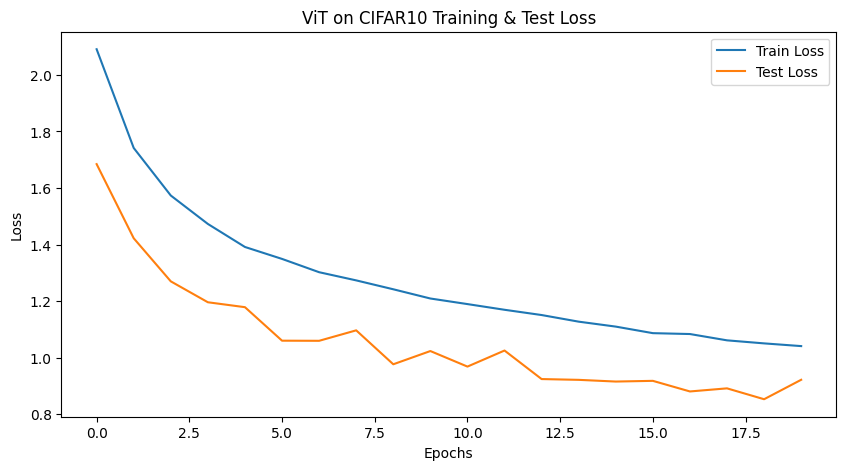

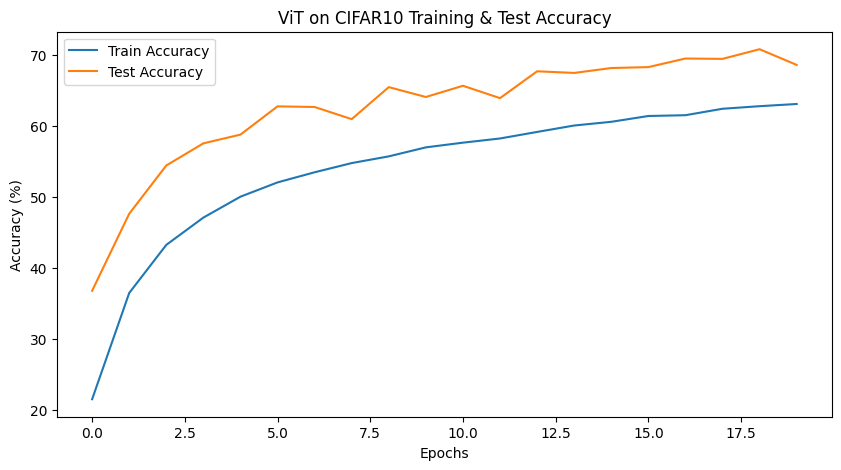

In [150]:
# Plot the training and test loss

# Plot Training and Test Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ViT on CIFAR10 Training & Test Loss")
plt.legend()
plt.show()

# Plot Training and Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("ViT on CIFAR10 Training & Test Accuracy")
plt.legend()
plt.show()

## Compact Convolutional Transformer
The previous network requires a lot of compute and data to be trained. As we mentionned before, the transformer removes the inductive bias of convnets which requires more data to be trained.

To bypass this, let's try out another architecture. We will try an hybrid architecture that preserves the inductive biases of convolution but manages to use the transformer to add global learning.

The first change is the tokenizer. We replace it with a ConvNet. Each convnet layer has a convolution, ReLU and maxpooling.
The second change is to actually remove the classfication token and classify on top of a pooling of all tokens. The pooling is done with an attention like mechanism:
- For each sample, we predict a scalar, that we compute the softmax over all the sample tokens.
- We then do an weighted average pool by this softmax values over the tokens. The weight is given by the previous step

More details see: https://arxiv.org/abs/2104.05704

<img src= https://miro.medium.com/v2/resize:fit:720/format:webp/1*8diH01Fl7MhHRemLy9hUHw.png width=512>

#### Question 11.
Implement the Convolutional based tokenizer and the SeqPool operationm

In [151]:
class ConvPatchEmbedding(nn.Module):
    def __init__(self, n_layers: int, kernel_size: int, hidden_dim: int):
        """
        Convolutional-based tokenizer for patch embedding.

        Args:
        - n_layers (int): Number of convolutional layers.
        - kernel_size (int): Size of the convolutional kernel.
        - hidden_dim (int): Dimension of the embedding.
        """
        # To complete
        super(ConvPatchEmbedding, self).__init__()

        layers = []
        in_channels = 3  # RGB input images
        for i in range(n_layers):
            # Ensure stride and kernel size do not reduce spatial dimensions too aggressively
            layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=hidden_dim,
                    kernel_size=kernel_size,
                    stride=1 if i == 0 else 2,  # First layer: stride=1, subsequent layers: stride=2
                    padding=kernel_size // 2,  # Preserve spatial dimensions
                )
            )
            layers.append(nn.ReLU())
            if i < n_layers - 1:  # Avoid pooling on the last layer
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = hidden_dim

        self.conv_layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for ConvPatchEmbedding.

        Args:
        - x (torch.Tensor): Input tensor of shape [batch_size, 3, height, width].

        Returns:
        - torch.Tensor: Output tensor of shape [batch_size, seq_len, hidden_dim].
        """
        # x = [batch size, 3, image height, image width]
        # To complete

        x = self.conv_layers(x)  # Convolutions + ReLU + MaxPooling
        batch_size, channels, height, width = x.shape

        if height == 0 or width == 0:
            raise ValueError(
                f"Invalid spatial dimensions after convolution: height={height}, width={width}. "
                "Adjust kernel_size, stride, or number of layers."
            )

        x = x.flatten(2).transpose(1, 2)  # Flatten spatial dimensions and transpose
        return x

class SeqPool(nn.Module):
    def __init__(self, hidden_dim:  int):
        """
        Sequence Pooling operation.

        Args:
        - hidden_dim (int): Dimension of the embedding.
        """
        # To complete
        super(SeqPool, self).__init__()

        # Linear layer to compute scalar weights for each token
        self.token_weight = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for SeqPool.

        Args:
        - x (torch.Tensor): Input tensor of shape [batch_size, seq_len, hidden_dim].

        Returns:
        - torch.Tensor: Pooled output tensor of shape [batch_size, hidden_dim].
        """
        # x = [batch size, seq len, hidden dim]
        # To complete

        # Compute weights for each token
        weights = self.token_weight(x)  # Shape: [batch_size, seq_len, 1]
        weights = torch.softmax(weights, dim=1)  # Apply softmax over the sequence dimension

        # Compute weighted sum
        pooled_output = torch.sum(weights * x, dim=1)  # Shape: [batch_size, hidden_dim]

        return pooled_output

#### Question 12.

Implement the Compact Convolutional Transformer.

In [152]:
class CCT(nn.Module):
    def __init__(
        self,
        n_conv_layers: int,
        kernel_size: int,
        n_transformer_layers: int,
        hidden_dim: int,
        n_heads: int,
        n_classes: int,
        dropout_rate: float = 0.1,
        ):
        """
        Compact Convolutional Transformer (CCT) Initialization.

        Args:
        - n_conv_layers (int): Number of convolutional layers in the tokenizer.
        - kernel_size (int): Kernel size for the convolutional layers.
        - n_transformer_layers (int): Number of transformer encoder layers.
        - hidden_dim (int): Dimension of the token embeddings.
        - n_heads (int): Number of attention heads in the transformer.
        - n_classes (int): Number of output classes for classification.
        - dropout_rate (float): Dropout rate for regularization.
        """
        # To complete

        super(CCT, self).__init__()

        # Convolutional Patch Embedding
        self.tokenizer = ConvPatchEmbedding(
            n_layers=n_conv_layers, kernel_size=kernel_size, hidden_dim=hidden_dim
        )

        # Positional Encoding
        self.positional_encoding = SinusoidalPositionalEncoding(hidden_dim)

        # Transformer Encoder
        self.transformer = TransformerEncoder(
            data_dim=hidden_dim,
            hidden_dim=hidden_dim * 4,  # FFN hidden size typically 4x input size
            n_heads=n_heads,
            n_layers=n_transformer_layers,
            dropout_rate=dropout_rate,
            positional_encoding="sinusoidal",
        )

        # Sequence Pooling for classification
        self.seq_pool = SeqPool(hidden_dim)

        # MLP Head for final classification
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, n_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the Compact Convolutional Transformer.

        Args:
        - x (torch.Tensor): Input tensor of shape [batch_size, 3, height, width].

        Returns:
        - torch.Tensor: Output logits of shape [batch_size, n_classes].
        """
        # x = [batch size, 3, image height, image width]
        # To complete

        # Tokenization with convolution
        x = self.tokenizer(x)  # [batch_size, seq_len, hidden_dim]

        # Add positional encoding
        x = self.positional_encoding(x)  # [batch_size, seq_len, hidden_dim]

        # Transformer encoder
        x = self.transformer(x)  # [batch_size, seq_len, hidden_dim]

        # Sequence pooling
        x = self.seq_pool(x)  # [batch_size, hidden_dim]

        # Classification head
        logits = self.mlp_head(x)  # [batch_size, n_classes]

        return logits

#### Question 13.
Train the CCT on CIFAR-10 for 100 epochs (for compute reason you can use only 20 epochs) and log both train and test loss and accuracy. You should obtain at least 75+% test accuracy, and observe a improvement compared to the previous ViT (Possible to get 90%+).
We provide a data augmentation strategy called auto augment to avoid overfitting on the training data.
Hparameters are to be choosen to your discretion.

Tips for Hparams:
- Don't use too big of a transformer hidden dim (<256)
- For the convnet, aim to have between 32 and 128 output tokens.
- Use AdamW with some weight decay to avoid overfitting
- Use between 2 and 6 transformer layers.
- Use between 2 and 4 transformer heads

Training takes around 30min (depending of hparams).

In [153]:
batch_size = 128
train_set = CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([
    transforms.autoaugment.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

test_set = CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]))

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [154]:
# To complete: train the model, (don't forget to test it)
# Hyperparameters
batch_size = 128
n_conv_layers = 4 #3
kernel_size = 5 #3
n_transformer_layers = 6 #4
hidden_dim = 192 #128
n_heads = 6 # 4
n_classes = 10
dropout_rate = 0.2 # 0.1
learning_rate = 5e-4 #1e-3
weight_decay = 5e-4 #1e-4
num_epochs = 25

# Initialize CCT
cct = CCT(
    n_conv_layers=n_conv_layers,
    kernel_size=kernel_size,
    n_transformer_layers=n_transformer_layers,
    hidden_dim=hidden_dim,
    n_heads=n_heads,
    n_classes=n_classes,
    dropout_rate=dropout_rate
).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(cct.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training and Evaluation
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(num_epochs):
    # Training
    cct.train()
    train_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cct(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(100.0 * correct / total)

    # Testing
    cct.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cct(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_losses.append(test_loss / len(test_loader.dataset))
    test_accuracies.append(100.0 * correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}% | "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")


Epoch [1/25]: Train Loss: 2.0314, Train Acc: 21.62% | Test Loss: 1.6231, Test Acc: 37.79%
Epoch [2/25]: Train Loss: 1.7253, Train Acc: 34.01% | Test Loss: 1.4278, Test Acc: 45.48%
Epoch [3/25]: Train Loss: 1.5128, Train Acc: 43.86% | Test Loss: 1.2404, Test Acc: 54.52%
Epoch [4/25]: Train Loss: 1.3422, Train Acc: 50.81% | Test Loss: 1.1154, Test Acc: 60.11%
Epoch [5/25]: Train Loss: 1.2421, Train Acc: 55.29% | Test Loss: 0.9707, Test Acc: 65.23%
Epoch [6/25]: Train Loss: 1.1463, Train Acc: 59.00% | Test Loss: 0.9245, Test Acc: 67.65%
Epoch [7/25]: Train Loss: 1.0811, Train Acc: 61.78% | Test Loss: 0.8937, Test Acc: 68.93%
Epoch [8/25]: Train Loss: 1.0345, Train Acc: 63.70% | Test Loss: 0.8533, Test Acc: 70.08%
Epoch [9/25]: Train Loss: 0.9868, Train Acc: 65.34% | Test Loss: 0.8348, Test Acc: 70.53%
Epoch [10/25]: Train Loss: 0.9469, Train Acc: 66.91% | Test Loss: 0.7929, Test Acc: 72.55%
Epoch [11/25]: Train Loss: 0.9206, Train Acc: 67.81% | Test Loss: 0.7933, Test Acc: 72.86%
Epoch [1

 ```
# Hyperparameters:
batch_size = 128
n_conv_layers = 3
kernel_size = 3
n_transformer_layers = 4
hidden_dim = 128
n_heads = 4
n_classes = 10
dropout_rate = 0.1
learning_rate = 1e-3
weight_decay = 1e-4
num_epochs = 25
```
 [25/25]: Train Loss: 0.8339, Train Acc: 70.79% | Test Loss: 0.7140, Test Acc: 75.87%

```
# Hyperparameters
batch_size = 128
n_conv_layers = 4
kernel_size = 5
n_transformer_layers = 6
hidden_dim = 192
n_heads = 6
n_classes = 10
dropout_rate = 0.2
learning_rate = 5e-4
weight_decay = 5e-4
num_epochs = 25
```

 [25/25]: Train Loss: 0.6626, Train Acc: 77.17% | Test Loss: 0.7105, Test Acc: 76.24%

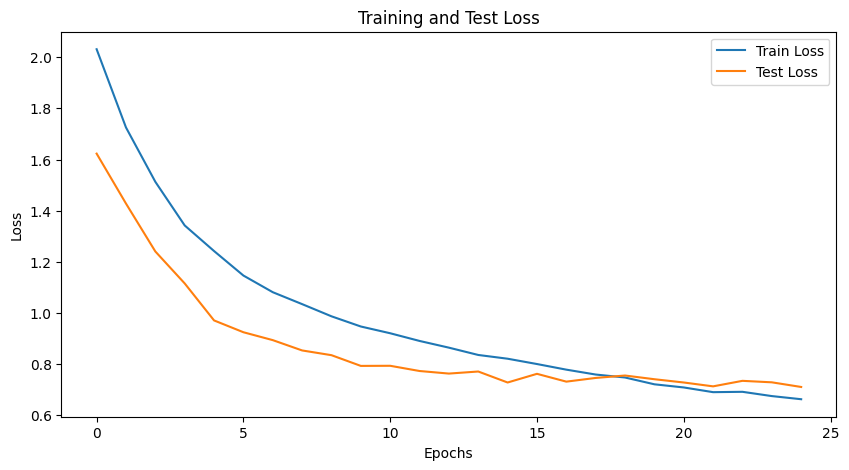

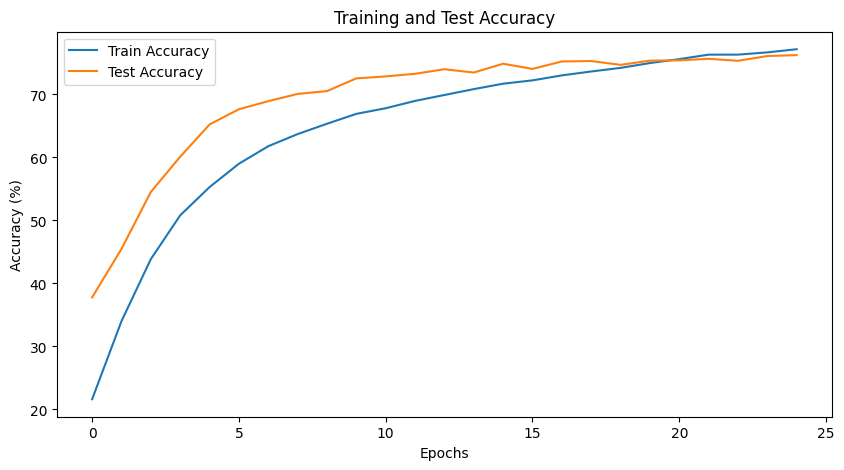

In [156]:
# Plot the training and test loss
# Plot Training and Test Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.show()

# Plot Training and Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy")
plt.legend()
plt.show()